In [1]:
#!pip install pillow

#### Load Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

#### Insight: determine the batch size number to use 

In [3]:
train_data_dir = 'ZhangLabData/CellData/chest_xray/train'
test_data_dir = 'ZhangLabData/CellData/chest_xray/test'

#Get all the data in the directory data/validation (132 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
       test_data_dir, 
       target_size=(64, 64), batch_size=132)

#Get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
       train_data_dir, 
       target_size=(64, 64), batch_size=790)

#Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


#### Preview images (Normal)

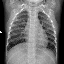

In [4]:
array_to_img(train_images[0])

In [5]:
print(train_labels[0])

[1. 0.]


#### Preview Images (Pneumonia)

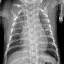

In [6]:
array_to_img(train_images[90])


In [7]:
print(train_labels[90])

[0. 1.]


In [8]:
print('train images shape: ',np.shape(train_images))
print('train labels shape: ',np.shape(train_labels))
print('test images shape: ',np.shape(test_images))
print('test labels shape: ',np.shape(test_labels))

train images shape:  (790, 64, 64, 3)
train labels shape:  (790, 2)
test images shape:  (132, 64, 64, 3)
test labels shape:  (132, 2)


#### Reshape and transpose images

In [24]:
#train set
train_img_unrow = train_images.reshape(790, -1)
train_img_unrow.shape

(790, 12288)

In [25]:
#test set
test_img_unrow = test_images.reshape(132, -1)
test_img_unrow.shape

(132, 12288)

#### Labels for images

In [11]:
train_labels

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [12]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

#### Transpose and resize train and test sets

In [30]:
#training set
train_labels_final = np.reshape(train_labels[:,0], (790,1))

In [31]:
np.shape(train_labels_final)

(790, 1)

In [32]:
#test set
test_labels_final = np.reshape(test_labels[:,0], (132,1))

In [33]:
np.shape(test_labels_final) 

(132, 1)

In [37]:
#scaling the data
train_img_final = train_img_unrow/255
test_img_final = test_img_unrow/255

type(test_img_unrow)

numpy.ndarray

In [38]:
print(train_img_final.shape)
print(test_img_final.shape)

(790, 12288)
(132, 12288)


### Baseline model creation

In [39]:
np.random.seed(42)
model = models.Sequential()
model.add(layers.Dense(25, activation='relu', input_shape=(12288,)))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) #output layer, binary classification

In [40]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

results = model.fit(train_img_final,
                    train_labels_final,
                    epochs=50,
                    batch_size=32,
                    validation_data=(test_img_final, test_labels_final))

Epoch 1/50
25/25 [==============================] - 0s 15ms/step - loss: 0.5775 - accuracy: 0.7468 - val_loss: 0.5658 - val_accuracy: 0.6515
Epoch 2/50
25/25 [==============================] - 0s 3ms/step - loss: 0.5097 - accuracy: 0.7456 - val_loss: 0.6478 - val_accuracy: 0.6591
Epoch 3/50
25/25 [==============================] - 0s 3ms/step - loss: 0.4949 - accuracy: 0.7468 - val_loss: 0.6065 - val_accuracy: 0.6439
Epoch 4/50
25/25 [==============================] - 0s 3ms/step - loss: 0.4365 - accuracy: 0.7848 - val_loss: 0.6482 - val_accuracy: 0.6439
Epoch 5/50
25/25 [==============================] - 0s 3ms/step - loss: 0.3889 - accuracy: 0.8025 - val_loss: 0.5333 - val_accuracy: 0.6591
Epoch 6/50
25/25 [==============================] - 0s 3ms/step - loss: 0.3648 - accuracy: 0.8291 - val_loss: 0.7102 - val_accuracy: 0.6515
Epoch 7/50
25/25 [==============================] - 0s 3ms/step - loss: 0.3733 - accuracy: 0.8443 - val_loss: 0.5356 - val_accuracy: 0.6515
Epoch 8/50
25/25 [=

In [41]:
results_train = model.evaluate(train_img_final, train_labels_final)

25/25 [==============================] - 0s 1ms/step - loss: 0.1260 - accuracy: 0.9519


In [42]:
results_test = model.evaluate(test_img_final, test_labels_final)

5/5 [==============================] - 0s 1ms/step - loss: 0.6803 - accuracy: 0.7727


#### Training accuracy = 0.9519. Test acc = 0.7727. Subsequent models must improve these thresholds.

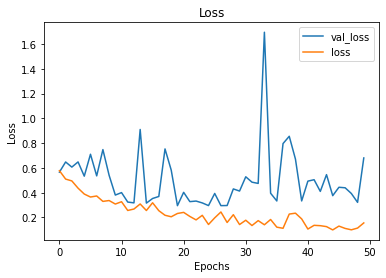

In [43]:
#plot acc vs loss for train and test set
history = results.history
plt.figure()
plt.plot(history['val_loss'])
plt.plot(history['loss'])
plt.legend(['val_loss', 'loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show();

#### Insight: according to the Loss plot, there is significant overfitting of the model due to the high variation of the validation curve, as well as the divergence of the two curves themselves. Any subsequent models must reduce the variance and overfitting of the baseline model.


#### For CNN: create convolution filter, padding (and maybe striding?) and pooling layer (if there are too many features)